# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [5]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [12]:
X_train_seq[1]

[55, 54, 82, 1673, 382]

In [13]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [14]:
X_train_seq_padded[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   55,   54,   82, 1673,  382])

### Build Model

In [15]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [16]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          253120    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 262,529
Trainable params: 262,529
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [20]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 9s 2ms/step - loss: 0.0018 - accuracy: 0.9993 - precision_m: 0.9857 - recall_m: 0.9822 - val_loss: 0.0452 - val_accuracy: 0.9865 - val_precision_m: 0.9514 - val_recall_m: 0.8960
Epoch 2/10
4457/4457 [==============================] - 9s 2ms/step - loss: 3.7287e-04 - accuracy: 1.0000 - precision_m: 0.9857 - recall_m: 0.9857 - val_loss: 0.0519 - val_accuracy: 0.9901 - val_precision_m: 0.9714 - val_recall_m: 0.9102
Epoch 3/10
4457/4457 [==============================] - 8s 2ms/step - loss: 2.4581e-04 - accuracy: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9883 - val_precision_m: 0.9586 - val_recall_m: 0.9102
Epoch 4/10
4457/4457 [==============================] - 9s 2ms/step - loss: 9.9497e-05 - accuracy: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9901 - val_precision_m: 0.9714 - val_recall_m: 0.9102
Epoc

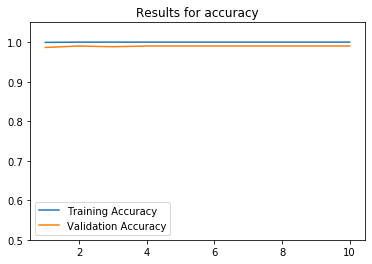

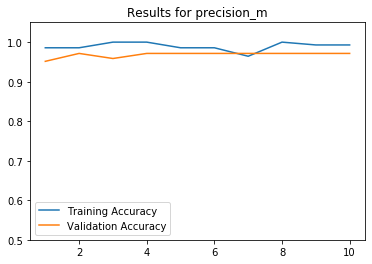

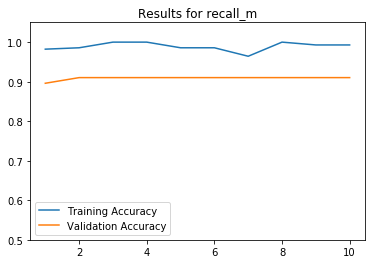

In [24]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.ylim([0.5, 1.05])
    plt.legend()
    plt.show()